In [15]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Our Robo-Advisor

## By: Kyle Kapoor, Justin Yi Cheng, Khush Mittal

### Portfolio Objective Summary:
Given a random list of stocks, generate a portfolio that deviates the LEAST from our original investment. The portfolio generated must succeed under these restrictions:
  1. Given an initial spending capital of \$750,000CAD. MUST invest ALL capital into chosen stocks.
  2. Flat fee of $4.95 for each STOCK purchased (not shares)
  3. Ignore issues of dividends
  4. IGNORE all stocks that do not have an average monthly volume of at least 150,000 shares
  5. IGNORE any stocks not denominated in either USD or CAD
  6. DROP months from stocks that do not have at least 18 trading days
  7. Pick a MINIMUM of 10 stocks and a MAXIMUM of 22 stocks
  8. Weight of each stock must have a MINIMUM of (100/(2n))% of the portfolio where 'n' is number of stocks picked.
  9. Weight of each stock must take a MAXIMUM of 20% of the portfolio

## Setup:
Code block below sets up ALL necessary information. Information is defaulted to fit within the given project restrictions. All code within this project is DYNAMIC, so ONLY variables within this code block must be edited to change the given project restrictions. Below code block gives the following:
  1. Flat fee
  2. Number of stocks purchased 
  3. Initial capital
  4. Mean monthly volume requirement
  5. Monthly trading days requirement
  6. Valid currencies
  7. Start-date and end-date (for picking Stocks)
  8. Start-date and end-date (for finding Weights)
  9. DataFrame of tickers from the .csv file

In [16]:
# Flat fee of purchasing a stock
flatFee = 4.95
# Number of stocks that we will purchase
numStocksPurchased = 22
# Total starting money
# Since we are purchasing 22 stocks, must subtract the (flatFee * numStocksPurchased)
moneyCAD = 750000 - (flatFee * numStocksPurchased)

# Sets the mean volume requirement (given from assignment)
meanMonthVolReq = 150000
# Sets the trading day requirements per month (given from assignment)
tradeDaysReq = 18
# Sets the valid currencies to be used.
validCurrencies = ['CAD', 'USD']

# Set start-date and end-date for picking Stocks (given from assignment)
start_date = '2023-01-01'
end_date = '2023-10-31'
# Set second start-date and end-date for finding weights on November 25th, 2023
start_date_1 = '2023-01-01'
end_date_1 = '2023-11-25'

# Creates a dataFrame of ALL the tickers
allTickStrDF = pd.read_csv("Real_Tickers.csv", header = None)

## Our Filter:
Code block below shows functions we used to filter through a given set a data that follows the set requirements:
 * getTickStrList(df) iterates from a provided DataFrame and checks if data is still valid on yFinance. If it is still valid, add it to the temporary list. If not valid, then do not add to the temporary list. Once we have looped through all values of the dataFrame, remove duplicate data from the list. Return the temporary list.
 
 * getTickHistoryList(str_list) takes a list of valid tickers and retrieves their historical stock price data. Converts stock prices from USD to CAD if original stock currency was in USD. We do this so all prices are weighed evenly in later calculations. Then it filters out all months with less than given amount of trading days.
   - getBadMonths(ticker) is a helper function that indentifies all months with less than the given trading days requiremnets.
 
 * filterTickList(str_list, hist_list) removes all data that are not in the correct currencyand does not mean the mean month volume requirement. Then it returns a nested list containing a filtered ticker list and a filtered history list.

In [37]:
# Takes all ticker strings from a dataFrame
# Code checks if each ticker is valid witin yFinance 
# If ticker is valid on yFinance, then adds ticker to the list
def getTickStrList(df):
    tempList = []
    
    for i in range(0, len(df), 1):
        strTick = df.iloc[i, 0].strip().partition('.')[0]
        tempTick = yf.Ticker(strTick)
        tickHistory = tempTick.history(start = start_date, end = end_date, interval = "1mo")
        
        # NEW Code
        # Checks if the tempTick.fast_info['currency'] exists as I need to check this specific data later
        try:
            tickInfoCurr = tempTick.fast_info['currency']
        except:
            print(f"Cannot get info of \'{df.iloc[i, 0]}.\'")
            continue
        
        tempTickCheck = tempTick._fetch_ticker_tz(proxy = None, timeout = 5)
        valid = yf.utils.is_valid_timezone(tempTickCheck)
        
        # NEW CODE
        # Added if the len(tickHistory) > 0 since null tickHistories should have length == 0
        # If len(tickHistory) is NOT > 0, then does not add to the list
        if (valid and len(tickHistory) > 0):
            # NEW CODE
            # Added _.strip() when addings strings to the list
            tempList.append(strTick)
            
    return list(dict.fromkeys(tempList))

# Converts all tickers from the dataFrame into yfinance objects
# If stock currency is in USD, transfer to CAD Prices to create uniformity
# Removes all months with less than 18 trading days
# Add edited ticker histories to the list
def getTickHistoryList(str_list):
    # Sets up a DataFrame that finds the daily USD to CAD exchange rates
    USDCAD = yf.Ticker("USDCAD=x")
    USDCADHist = USDCAD.history(start = start_date, end = end_date, interval = "1mo")
    USDCADHist.index = pd.DatetimeIndex(USDCADHist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')
    USDCADHist.index = USDCADHist.index.strftime("%Y-%m")

    tempList = []    
    
    for i in range(0, len(str_list), 1):
        # Creates a ticker history DataFrame of a given ticker
        tempTick = yf.Ticker(str_list[i])
        tempTickHistory = tempTick.history(start = start_date, end = end_date, interval = "1mo")
        tempTickHistory.index = pd.DatetimeIndex(tempTickHistory.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')
        tempTickHistory.index = tempTickHistory.index.strftime("%Y-%m")
        
        # If the currency is into USD, then conver the prices to CAD
        if tempTick.fast_info['currency'] == 'USD':
            tempTickHistory['Close'] *= USDCADHist['Close']
        
        # Gets the list of bad months (do not meet trading days requirement)
        badMonthList = getBadMonths(str_list[i])
        tempIndex = 0
        
        # Runs through the list of badMonths and removes the badMonths from the history
        while len(badMonthList) > 0:
            currentMonth = datetime.strptime(tempTickHistory.index[tempIndex], "%Y-%m").month
            
            if currentMonth == badMonthList[0]:
                tempTickHistory = tempTickHistory.drop(index = tempTickHistory.index[tempIndex])
                badMonthList.pop(0)
                tempIndex -= 1
        
            tempIndex += 1
        
        tempList.append(tempTickHistory)

    return tempList

# Function that determines whether certain months fit within the trading days requirement
# If it does not fufill the requiremnet, add it to the list
def getBadMonths(ticker): 
    # Creates a ticker history DataFrame of a given ticker
    tempTick = yf.Ticker(ticker)
    tempTickHistory = tempTick.history(start = start_date, end = end_date, interval = "1d")
    tempTickHistory.index = pd.DatetimeIndex(tempTickHistory.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')
    tempTickHistory.index = tempTickHistory.index.strftime("%Y-%m-%d")
    
    badMonthList = []
    tempCounter = 0    
    
    # Finds the list of bad months that do not meet the trading day requirement
    for i in range(0, len(tempTickHistory) - 1, 1):
        todayMonth = datetime.strptime(tempTickHistory.index[i], "%Y-%m-%d").month
        tomorrowMonth = datetime.strptime(tempTickHistory.index[i + 1], "%Y-%m-%d").month
        
        if todayMonth == tomorrowMonth:
            tempCounter += 1
        else:
            if tempCounter < tradeDaysReq:
                badMonthList.append(todayMonth)
                tempCounter = 0
    
    return badMonthList

# Filters through a tick list of histories using the given requirements:
#     1. If the stock does not meet the monthly volume requirement, then do not add it
#     2. If any stock is not in the currency USD or CAD, then do not add it
# Returns a nested list that contains the list of tickers & list of edited histories of the tickers
def filterTickList(str_list, hist_list):
    tempHistList = []
    tempStrList = []
    
    for i in range(0, len(hist_list), 1):
        tempTick = yf.Ticker(str_list[i])
        tickCurr = tempTick.fast_info['currency']
        
        # Check if currency is one of the valid currencies
        if tickCurr not in validCurrencies:
            continue;
        # Checks if stock meets the volume requirements
        elif hist_list[i]['Volume'].mean() < meanMonthVolReq:
            continue;
        else:
            tempStrList.append(str_list[i])
            tempHistList.append(hist_list[i]);
        
    return [tempStrList, tempHistList]

Uses the functions above to store the data into variables.

In [38]:
# Obtain a list of all valid ticker strings
tickStringList = getTickStrList(allTickStrDF)

# Obtain a list of all ticker histories
tickList = getTickHistoryList(tickStringList)

# Filters the history list given the conditions (previous code)
tickListFiltered = filterTickList(tickStringList, tickList)

tickStringList

WWEAA: No timezone found, symbol may be delisted


Cannot get info of 'wweaa.'


INVALIDT: No timezone found, symbol may be delisted


Cannot get info of 'INVALIDT.'


HDFC: No timezone found, symbol may be delisted


Cannot get info of 'HDFC.NS.'


CELG: No timezone found, symbol may be delisted


Cannot get info of 'CELG.'


CNR: No timezone found, symbol may be delisted
SBIN: No timezone found, symbol may be delisted


Cannot get info of 'CNR.TO.'
Cannot get info of 'SBIN.NS.'


GWO: No price data found, symbol may be delisted (1mo 2023-01-01 -> 2023-11-25)


['ACRV',
 'AAPL',
 'ABBV',
 'AUST',
 'PAPL',
 'BMO',
 'AMZN',
 'OTEX',
 'SU',
 'BMBL',
 'BK',
 'SQ',
 'VZ',
 'CMCSA',
 'SHOP',
 'COST',
 'CSCO',
 'CVS',
 'PPL',
 'GOOG',
 'IBM',
 'ORCL',
 'TD',
 'T',
 'SLB',
 'SO',
 'SPG',
 'CNI',
 'K']

## Selecting Our Stocks:

A function named getPercentDataFrame(llst) is defined to calculate the monthly percentage returns for each stock in the filtered ticker list and their corresponding historical data. The function takes the nested list "llst" as input, where the first element is a list of filtered ticker strings (tempStrList) and the second element is a list of filtered ticker histories (tempHistList).

Within the function, an empty DataFrame named percentDataFrame is initialized to store the calculated monthly returns. A for loop iterates through each stock's historical data, calculates the percentage change in the 'Close' prices using the pct_change() method, and appends the results as a new column in the percentDataFrame. This column is labeled with the respective ticker string.

After calculating the percentage returns, the first row containing NaN values resulting from the percentage change operation is dropped using the drop function.

The final output of the function is the percentDataFrame containing monthly percentage returns for each stock. Outside the function, the percentDF variable is assigned the result of calling getPercentDataFrame(tickListFiltered), and the first few rows of this DataFrame are displayed.

In [19]:
def getPercentDataFrame(llst):

    # Initialize an empty DataFrame to store monthly returns
    percentDataFrame = pd.DataFrame()
        
    # Calculate monthly returns for the 'Close' prices and append to the overall DataFrame
    for i in range(0, len(llst[1]), 1):
        tempPercentages = llst[1][i]['Close'].pct_change()
        percentDataFrame[llst[0][i]] = tempPercentages

    # Drop the first row containing NaN values
    percentDataFrame.drop(index =  percentDataFrame.index[0], inplace = True)

    return percentDataFrame

percentDF = getPercentDataFrame(tickListFiltered)
percentDF.head()

,ACRV,AAPL,ABBV,AUST,BMO.TO,AMZN,OTEX.TO,SU.TO,BMBL,BK,...,TD.TO,T.TO,SLB,SO,SPG,SHOP.TO,CNI,CNR.TO,GWO.TO,K.TO
Date,,,,,,,,,,,,,,,,,,,,,
2023-02,0.272146,0.036142,0.066469,-0.181187,-0.023883,-0.073314,0.052431,-0.006929,-0.047626,0.028205,...,-0.002359,-0.053715,-0.052893,-0.055021,-0.036081,-0.143206,-0.030074,-0.018752,0.054973,-0.185784
2023-03,-0.377889,0.116057,0.031568,0.290482,-0.069131,0.091941,0.109857,-0.085041,-0.194584,-0.110346,...,-0.108971,-0.011058,-0.076434,0.110626,-0.086410,0.153435,0.031849,0.026124,-0.037873,0.261905
2023-04,-0.020755,0.038735,-0.042783,-0.096787,0.014537,0.030584,-0.008707,0.022337,-0.059718,-0.053841,...,0.013836,0.084375,0.014613,0.067071,0.036921,0.012963,0.025596,0.017687,0.090494,0.082778
2023-05,-0.046581,0.040764,-0.082080,-0.003685,-0.061919,0.139267,0.099980,-0.103489,-0.162898,-0.051194,...,-0.052554,-0.104457,-0.135316,-0.055160,-0.075516,0.183272,-0.058316,-0.052260,-0.002336,-0.062958
2023-06,0.071880,0.067666,-0.048524,-0.148932,0.056704,0.053309,-0.023742,0.021825,0.068531,0.078986,...,0.068584,0.002333,0.117370,-0.009441,0.070001,0.102356,0.046366,0.048086,0.014368,-0.006072


## Measuring The Standard Deviation:

A function named getLowToHighSTD(pD) is defined to compute the standard deviations of monthly returns for each stock in the given DataFrame pD. The function takes the percentage DataFrame (percentDF) as input, where each column represents the monthly percentage returns of a specific stock.

Within the function, an empty DataFrame named stdDataFrame is initialized to store the standard deviations of monthly returns. The for loop iterates through each column in the input DataFrame (pD), which corresponds to a specific stock's monthly returns. The standard deviation of each stock's monthly returns is calculated using the std() method and added to the stdDataFrame under the column labeled 'Standard Deviation'.

After computing the standard deviations, the stdDataFrame is sorted in ascending order based on the 'Standard Deviation' column using the sort_values method. This sorting operation allows for easy access to stocks with the lowest standard deviation.

The final output of the function is a list named lowToHighSTD, which contains the tickers of stocks sorted from low to high standard deviation.

In [20]:
def getLowToHighSTD(pD):
    
    # Compute standard deviations of monthly returns
    stdDataFrame = pd.DataFrame()
    stdDataFrame['Standard Deviation'] = "" 
    
    for i in range(0, len(pD.columns), 1):
        stdDataFrame.loc[pD.columns[i]] = pD.iloc[:, i].std()
    
    # Sort standard deviations for easy access to low std stocks
    stdDataFrame.sort_values(by = 'Standard Deviation', inplace = True)
    
    # Extract stocks with the lowest standard deviation
    lowtoHighSTDStocksList = stdDataFrame.index.tolist()

    return lowtoHighSTDStocksList

lowToHighSTD = getLowToHighSTD(percentDF)

## Measuring The Correlation:

A correlation analysis is conducted on the DataFrame percentDF, which contains the monthly percentage returns of different stocks. The first line of code generates a correlation matrix (compareStockCorr) using the .corr() function on the DataFrame. This matrix represents the pairwise correlations between all the stocks in the portfolio.

Following this, the correlation matrix is reshaped to provide a clearer representation of the pairwise stock correlations. The stack() method is employed to transform the matrix into a Series with a multi-level index, where each level corresponds to the original row and column indices of the matrix. This Series is then reset using the reset_index() method, making the date indices irrelevant for comparing correlation values between stocks.

Subsequently, the column names of the reshaped DataFrame (compareStockCorr) are renamed to enhance clarity. The columns are labeled 'Stock A', 'Stock B', and 'Correlation Value', indicating the two stocks being compared and the correlation value between them, respectively.

The final output of this code segment is the reshaped and labeled DataFrame, which provides a concise and organized representation of the pairwise correlations between different stocks.

In [21]:
# Generate a correlation matrix of pairwise stock correlations
compareStockCorr = percentDF.corr()

# Reshape the correlation matrix into columns that compares the corrleation of two stocks against each other
# Reset the index since dates are not relevant when comparing correlation value of stocks
compareStockCorr = compareStockCorr.stack().reset_index()
compareStockCorr.index += 1

# Rename correlation column names to enhance clarity
compareStockCorr.columns = ['Stock A', 'Stock B', 'Correlation Value']
compareStockCorr.head()

,Stock A,Stock B,Correlation Value
1,ACRV,ACRV,1.000000
2,ACRV,AAPL,-0.034076
3,ACRV,ABBV,0.166022
4,ACRV,AUST,-0.674778
5,ACRV,BMO.TO,0.598770


## Negative Correlations:

A function named getLowToHighCorr(compareDF) is defined to identify stocks with the lowest negative correlations in the pairwise correlation DataFrame (compareDF). This DataFrame represents the correlations between different stocks calculated in the previous code. The function returns a nested list (tempList) containing pairs of stocks with the lowest negative correlations.

The function begins by creating a copy of the input DataFrame (compareDF) named tempCompareDF. An empty list (tempList) is initialized to store the results.

The while loop continues execution as long as the minimum correlation value in tempCompareDF is less than 0 (thereby giving a negative correlation) or the DataFrame is not empty. Within the loop, the minimum correlation value (minCorr) is identified, and a new DataFrame (dFMinCorr) is created containing stocks with a correlation value equal to the minimum. The stocks with the minimum correlation value are extracted and appended to the tempList.

Subsequently, the DataFrame tempCompareDF is filtered to remove all instances of stocks that have been added to the list, ensuring that stocks are not repeated. This process continues until all pairs of stocks with the lowest negative correlations are identified.

The final output of the function is the nested list lowToHighCorr, which contains pairs of stocks sorted from low to high negative correlations.

In [22]:
# Returns a nested-list of the lowest correlations of stocks
# Only return nested stocks that have a negative correlation
def getLowToHighCorr(compareDF):
    # Creates a copy of the comparison correlation DataFrame
    tempCompareDF = compareDF.copy()
    tempList = []
    
    # While the minimum correlation-value is less than 0 or if the temporary DataFrame is empty...
    while (tempCompareDF['Correlation Value'].min() < 0) or (not tempCompareDF.empty):
        # Finds the minimum correlation-value
        minCorr = tempCompareDF['Correlation Value'].min()
        # Returns a dataframe of stocks that have a correlation value equal to the minimum
        dFMinCorr = tempCompareDF[tempCompareDF['Correlation Value'] == minCorr]
        # Return the stocks and puts them in a list
        stocksMinCorr = [dFMinCorr.iloc[0, 1], dFMinCorr.iloc[0, 0]]
        # Appends the list into a bigger list
        tempList.append(stocksMinCorr)
        
        # Filters out all instances of implemented stocks we added to the list
        tempCompareDF = tempCompareDF[~(tempCompareDF == stocksMinCorr[0]).any(axis = 1)]
        tempCompareDF = tempCompareDF[~(tempCompareDF == stocksMinCorr[1]).any(axis = 1)] 
    
    return tempList

lowToHighCorr = getLowToHighCorr(compareStockCorr)

## Generating The Best Portfolio:

Two lists are created: lowSTD22 and lowCorr22. The first list, lowSTD22, contains the first 22 stocks from the list of stocks with the lowest standard deviation (lowToHighSTD). The second list, lowCorr22, contains the first 11 pairs of stocks from the list of pairs with the lowest negative correlation (lowToHighCorr). These lists will be used in the subsequent functions for portfolio optimization.

Two functions, calculatePortfolioSTD(list) and findPerfectPortfolio(), are defined to calculate the standard deviation of a given portfolio and find the optimal portfolio, respectively.

The calculatePortfolioSTD(list) function takes a list of stocks as input, retrieves their monthly returns from the percentDF DataFrame, sums the returns for each month to obtain the portfolio returns, and then calculates and returns the standard deviation of the portfolio returns.

The findPerfectPortfolio() function initializes two sets of variables: previousStocks and currentStocks. It iterates over the pairs of stocks with the lowest correlation (lowCorr22). For each pair, it adjusts the currentStocks list by replacing two stocks with the pair, ensuring there are no duplicates in the list. The function then iteratively adds stocks from the list with the lowest standard deviation (lowSTD22) to obtain a portfolio of 22 stocks. The standard deviation of the resulting portfolio is calculated and compared with the standard deviation of the previous portfolio. If the new portfolio has a lower standard deviation, it becomes the current portfolio. The function continues this process until all pairs from lowCorr22 have been considered.

The final output of the findPerfectPortfolio() function is the list of stocks (bestPortfolio) that form the optimal portfolio with the lowest standard deviation based on the criteria outlined in the assignment rubric.

In [23]:
# Creates a list of the first 22 stocks that have the lowest standard deviation
lowSTD22 = lowToHighSTD[0:numStocksPurchased]

# Creates a list of the first 22 stocks that have the lowest correlation
lowCorr22 = lowToHighCorr[0:(numStocksPurchased // 2)]

# Calculates the overall std of the portfolio
def calculatePortfolioSTD(stock_list):
    # Calculate and return the standard deviation of the portfolio returns
    portfolioReturns = percentDF[stock_list].sum(axis=1)
    return portfolioReturns.std()

# Finds the perfect portfolio
def findPerfectPortfolio():
    # Initialize variables with the first set of low standard deviation stocks
    previousStocks = lowSTD22
    currentStocks = lowSTD22
    previousSTD = calculatePortfolioSTD(previousStocks)
    currentSTD = 0
    
    # Iterate over pairs with low correlation to optimize the portfolio
    for i in range(0, len(lowCorr22), 1):
        # Remove highest-standard deviation stocks (when are found at the END of the list)
        currentStocks = currentStocks[:-2]
        # Inserts the negatively correlated stocks to the BEGINNNG of the list
        currentStocks.insert(0, lowCorr22[i][0])
        currentStocks.insert(0, lowCorr22[i][1])
        
        # Ensure uniqueness in the list (no duplicates)
        currentStocks = list(set(currentStocks))
        
        # In the case of duplicates, the length of currentStocks will not be equal to the desired number of stocks purchased
        # In this case, we want to add in the lowest-standard deviation stock back into the list
        
        tempIndex = 0        
        while len(currentStocks) < numStocksPurchased:            
            if lowToHighSTD[tempIndex] not in currentStocks:
                currentStocks.append(lowToHighSTD[tempIndex])
            
            tempIndex += 1
        
        # Calculate the standard deviation of the current portfolio
        currentSTD = calculatePortfolioSTD(currentStocks)
        
        # Update the portfolio if the current standard deviation is lower than the previous
        if currentSTD < previousSTD:
            previousStocks = currentStocks
            previousSTD = currentSTD
    
    return previousStocks

bestPortfolio = findPerfectPortfolio()

## Optimal Weighting:

A set of functions has been defined to streamline the creation and evaluation of portfolios with optimized weighting. The portfolio(df, stocks) function facilitates the construction of a DataFrame (df) containing columns for closing prices and daily returns of a specified list of stock tickers (stocks). Using yfinance, individual stock data is retrieved, and the resulting DataFrame is enriched with columns labeled with the stock's name followed by 'closing' and 'returns'.

The weightedportfolio(stocks, weight, main) function calculates the portfolio value and daily returns based on provided stock weights. It iterates through dates in the main DataFrame, updating the portfolio value using the given weights. The resulting portfolio returns and standard deviation are added to the main DataFrame, and the function returns the standard deviation of the portfolio returns.

The generate_portfolios(tickers, number_of_portfolios) function systematically generates a specified number of portfolios with random weights and evaluates their standard deviations. It initializes a DataFrame (main) using the portfolio function to store closing prices and returns for each stock. Iteratively, it generates portfolios with random weights using the weightedportfolio function. The standard deviations of portfolio returns and their corresponding weights are stored in lists, and a DataFrame (portfolios) is printed for inspection. The function identifies and returns the weights corresponding to the portfolio with the minimum standard deviation. In the latter part of the code, we have created 2000 portfolios with random weights that add upto 100 the weights of portfolio with smallest standard deviation will be returned. It's not gonna be exactly the most optimal weights but it will give a very close value and the value will get closer and closer when the number of randomly generated portfolios increase. As an arbitary value we are taking that the number of portfolios to be generated as 2000. 

These functions collectively provide a framework for creating and analyzing portfolios with diverse stock weights. The generate_portfolios function, in particular, enables the exploration of different weight combinations, aiding in the identification of an optimal portfolio with minimized standard deviation.

In [24]:
# Creates a portfolio with columns for closing prices and returns of each stock
def portfolio(df, stocks):
    
    for i in stocks:
        
        # Fetch stock data using yfinance
        name = yf.Ticker(i)
        hist = name.history(start = start_date_1, end = end_date_1, interval = '1d')
        hist.index = hist.index.strftime('%Y-%m-%d')
        # df.index = hist.index
        df[('%s closing' % (i))] = hist.Close
        prices = df[('%s closing' % (i))]

        # Calculate daily returns and add to the DataFrame
        daily_returns = prices.pct_change()
        df[('%s returns' % (i))] = daily_returns * 100

# Calculates portfolio value and returns standard deviation for a given set of weights
def weightedportfolio(stocks, weight, main): 
    portfolio_total = moneyCAD - (len(stocks) * flatFee)
    portval = []

    for j in main.index:
        portfolio = 0
        for i in range(len(stocks)):
            perstock = ((weight[i]) / 100) * portfolio_total
            # NEW CODE
            # Changed from '2023-11-25' to '2023-11-24'
            closing = main.loc['2023-11-24', stocks[i] + ' closing']
            number = perstock / closing
            portfolio += (main.loc[j, stocks[i] + ' closing']) * number
        portval.append(portfolio)

    # Add portfolio value and calculate daily returns    
    main['Portfolio Value'] = portval
    main = main.ffill()
    dailyreturns = main['Portfolio Value'].pct_change()

    # Add daily returns and calculate standard deviation
    main['Portfolio Return'] = dailyreturns * 100
    std = main['Portfolio Return'].std()

    # Drop unnecessary columns and return standard deviation
    main.drop(columns=['Portfolio Return'], inplace=True)
    main.drop(columns=['Portfolio Value'], inplace=True)

    return std 

# Generates portfolios with random weights and returns weights with the lowest standard deviation
def generate_portfolios(tickers, number_of_portfolios):
    weights = []
    standard_deviations = []
    range_start = (100 / (2 * (len(tickers))))  # Weights In Percent
    range_end = 20  # Weights In Percent
    main = pd.DataFrame()
    portfolio(main, tickers)

    for i in range(number_of_portfolios):
        
        # Generate random weights
        sample_weights = np.random.random(len(tickers)) * (range_end - range_start) + range_start
        sample_weights /= sample_weights.sum()
        sample_weights *= 100
        weights.append(sample_weights)

        # Evaluate standard deviation for the portfolio
        d = weightedportfolio(tickers, sample_weights, main)
        standard_deviations.append(d)

    # Create a DataFrame with standard deviations and corresponding weights    
    portfolios = pd.DataFrame(index=range(number_of_portfolios))
    portfolios['Standard_Deviation'] = standard_deviations
    portfolios['Corresponding_Weights'] = weights
    print(portfolios)
    
    plt.plot(portfolios.index, portfolios['Standard_Deviation'].values.tolist(),label='Standard Deviation',linewidth=4)
    plt.title('Standard Deviation of each of the 2000 random portfolio')
    plt.xlabel('Random Portfolio Number')
    plt.ylabel('Standard Deviation')
    plt.legend(loc='best')
    plt.tight_layout()

    # Identify and return the weights corresponding to the minimum standard deviation
    minimum_index = standard_deviations.index(min(standard_deviations))
    weights_min_sd = weights[minimum_index]
    print(min(standard_deviations))
    return weights_min_sd

## Data Extraction:
Three functions are defined to facilitate the extraction of data related to stock tickers.
 * getTickHistoryList_RegPrice(str_list) retrieves the historical stock price data for a given list of ticker strings without converting USD to CAD. 
 
 * getCurr(strList), takes a list of ticker strings as input and returns a list of corresponding currencies.
 
* getPrices(histList), takes a list of ticker histories as input and returns a list of the most recent closing prices for each stock.

In [25]:
# Does the same as getTickHistoyList, but does not convert all USD to CAD
def getTickHistoryList_RegPrice(str_list):
    tempList = []    
    
    # Iterate through the provided list of ticker strings
    for i in range(0, len(str_list), 1):
        # Retrieve historical data for each ticker
        tempTick = yf.Ticker(str_list[i])
        tempTickHistory = tempTick.history(start = start_date, end = end_date, interval = "1mo")
        # Clean and format the date index
        tempTickHistory.index = pd.DatetimeIndex(tempTickHistory.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')
        tempTickHistory.index = tempTickHistory.index.strftime("%Y-%m")
        
        # Remove months with insufficient trading days
        badMonthList = getBadMonths(str_list[i])
        tempIndex = 0
        
        while len(badMonthList) > 0:
            currentMonth = datetime.strptime(tempTickHistory.index[tempIndex], "%Y-%m").month
            
            if currentMonth == badMonthList[0]:
                tempTickHistory = tempTickHistory.drop(index = tempTickHistory.index[tempIndex])
                badMonthList.pop(0)
                tempIndex -= 1
        
            tempIndex += 1
        
        # Append the cleaned historical data to the list
        tempList.append(tempTickHistory)

    return tempList

# Gets the currency and puts it all into a list
def getCurr(strList):
    tempList = []
    
    # Iterate through the provided list of ticker strings
    for i in range(0, len(strList), 1):
        # Retrieve the currency information for each ticker
        tempList.append(yf.Ticker(strList[i]).fast_info['currency'])
    
    return tempList

# Gets the prices and puts it all into a list
def getPrices(histList):
    tempList = []
    
    # Iterate through the provided list of ticker histories
    for i in range(0, len(histList), 1):
        # Extract the most recent closing price for each stock
        tempList.append(histList[i].iloc[len(histList[i]) - 1, 3])
    
    return tempList

In [26]:
# Set to end-date of the given assignment
end_date = end_date_1

# Obtain historical data for stocks in the bestPortfolio with currency conversion (USD to CAD)
bestTickList = getTickHistoryList(bestPortfolio)
bestTickFilteredList = filterTickList(bestPortfolio, bestTickList)

# Obtain historical data for stocks in the bestPortfolio without currency conversion
bestTickList_RegPrice = getTickHistoryList_RegPrice(bestPortfolio)
bestTickFilteredList_RegPrice = filterTickList(bestPortfolio, bestTickList_RegPrice)

## Final Touches:
The variable weightDecider is responsible for determining the weight of each stock in the portfolio based on the stipulations above. The DataFrame Portfolio_Final is initialized to capture essential information about the selected stocks, including their tickers, currencies, prices, weights, values in CAD, and the corresponding number of shares.

C:\Users\Justin Yi Cheng\AppData\Local\Temp\ipykernel_9608\3206786065.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = prices.pct_change()
C:\Users\Justin Yi Cheng\AppData\Local\Temp\ipykernel_9608\3206786065.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = prices.pct_change()
C:\Users\Justin Yi Cheng\AppData\Local\Temp\ipykernel_9608\3206786065.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = prices.pct_change()
C:\Users\Justin Yi Che

      Standard_Deviation                              Corresponding_Weights
0               0.708110  [5.44536113717868, 9.816827523636285, 7.038866...
1               0.713495  [2.561525997239553, 4.299922371599632, 5.84322...
2               0.730633  [6.190691778851779, 6.847222762100413, 3.16742...
3               0.732998  [8.78827821500075, 5.2642521864180996, 1.40980...
4               0.755970  [7.034458805275183, 3.9628287323413143, 0.9063...
...                  ...                                                ...
1995            0.711742  [3.760724591255313, 4.075083912867758, 2.68070...
1996            0.742614  [5.271929707442342, 4.95015392709328, 4.845013...
1997            0.688200  [6.08801471277266, 5.951444137734272, 7.209944...
1998            0.704716  [4.120299030012053, 1.9701967807021172, 1.0764...
1999            0.709065  [4.794384724732103, 6.880895631623946, 3.25021...

[2000 rows x 2 columns]
0.6599978202691087


,Ticker,Currency,Price,Weight,Value (CAD),Shares
1,COST,USD,591.654175,0.033885,25409.741505,31.60141
2,CNR.TO,CAD,157.460007,0.038293,28715.940583,182.369741
3,IBM,USD,156.781906,0.045766,34319.753764,161.072862
4,CNI,USD,115.949997,0.013918,10437.167547,66.234775
5,GWO.TO,CAD,42.851673,0.052005,38998.095967,910.071722
6,PPL.TO,CAD,45.389999,0.088549,66402.260174,1462.9271
7,BMO.TO,CAD,111.379997,0.029160,21866.682913,196.325044
8,AAPL,USD,189.700073,0.076787,57581.731205,223.352785
9,TD.TO,CAD,82.739998,0.033086,24811.048212,299.867644
10,BK,USD,48.32,0.023712,17781.373588,270.777477


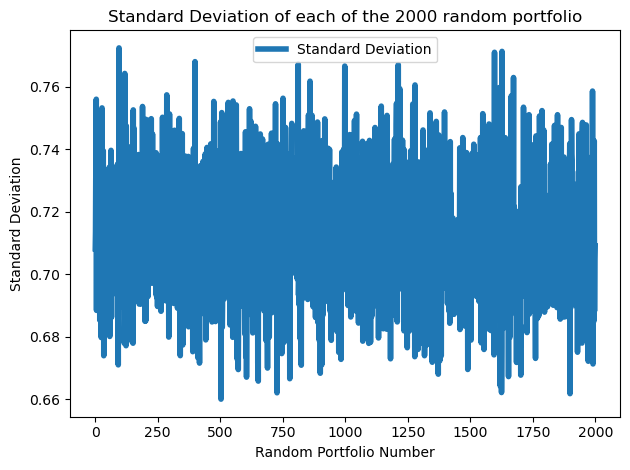

In [27]:
weightDecider = generate_portfolios(bestTickFilteredList[0],2000)

# Initialize an empty DataFrame for the final portfolio
Portfolio_Final = pd.DataFrame()

# Populate the 'Ticker' column with the tickers of filtered stocks from bestTickFilteredList
Portfolio_Final['Ticker'] = bestTickFilteredList[0]

# Populate the 'Currency' column with the currencies of the selected stocks
Portfolio_Final['Currency'] = getCurr(bestTickFilteredList[0])

# Populate the 'Price' column with the most recent closing prices of the selected stocks
Portfolio_Final['Price'] = getPrices(bestTickFilteredList_RegPrice[1])

# Assign calculated weights to the 'Weight' column based on weightDecider
Portfolio_Final['Weight'] = weightDecider
Portfolio_Final['Weight'] *= (1/100)

# Calculate the 'Value (CAD)' column representing the overall value of shares purchased for each stock
Portfolio_Final['Value (CAD)'] = (moneyCAD * Portfolio_Final['Weight'])

# Calculate the 'Shares' column representing the number of shares purchased for each stock
# NEW CODE: 
Portfolio_Final['Shares'] = Portfolio_Final['Value (CAD)'] / getPrices(bestTickFilteredList[1])

# Add a final row to represent the total weight and value of the portfolio
Portfolio_Final.loc[len(Portfolio_Final)] = ['---', '---', '---', Portfolio_Final['Weight'].sum(), Portfolio_Final['Value (CAD)'].sum() + (flatFee * numStocksPurchased), '---']

# Adjust the index to start from 1 as per the assignment requirement
Portfolio_Final.index += 1

# Display the final portfolio DataFrame
Portfolio_Final

## Conclusion:

The final step of the portfolio construction process is now executed below. The DataFrame Stocks_Final is created by selecting specific columns from the previously constructed Portfolio_Final DataFrame. The columns chosen are 'Ticker' and 'Shares,' representing the stock tickers and the corresponding number of shares purchased for each stock in the portfolio.

The index of Stocks_Final is adjusted to start from 1 using the statement Stocks_Final.index += 1. This aligns with the assignment's requirement for the index of the final DataFrame.

Finally, the to_csv function is applied to export the Stocks_Final DataFrame to a CSV file named "Stocks_Group_05.csv." The filename includes our group number. This CSV file will serve as the final result containing the relevant information about the selected stocks and the corresponding number of shares in the final portfolio.

In [28]:
# Convert to CSV
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
Stocks_Final.to_csv("Stocks_Group_05.csv")